🖼️  Running Inference on Normal Images...
Running inference on: dfb40c367e569e38a267d7777d8408a2.jpg

image 1/1 /kaggle/input/rgb-images/dfb40c367e569e38a267d7777d8408a2.jpg: 384x640 1 humans, 62.0ms
Speed: 13.2ms preprocess, 62.0ms inference, 448.5ms postprocess per image at shape (1, 3, 384, 640)


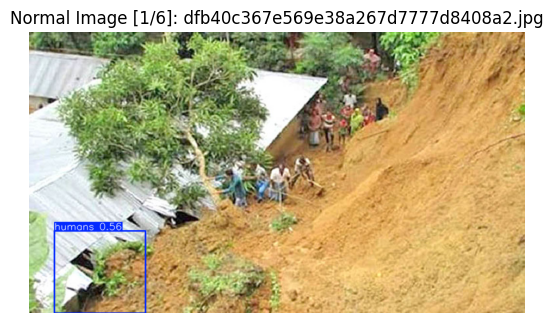

-------------------------
Running inference on: image.jpg

image 1/1 /kaggle/input/rgb-images/image.jpg: 416x640 1 humans, 58.2ms
Speed: 1.8ms preprocess, 58.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


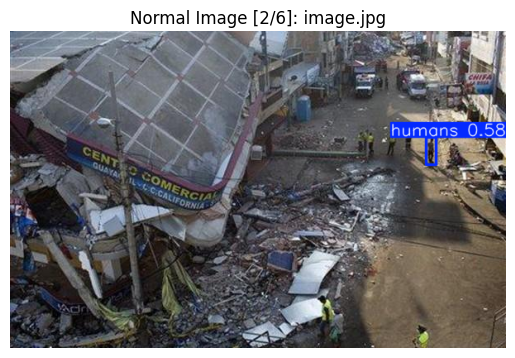

-------------------------
Running inference on: Screenshot (379).png

image 1/1 /kaggle/input/rgb-images/Screenshot (379).png: 384x640 1 humans, 46.4ms
Speed: 2.4ms preprocess, 46.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


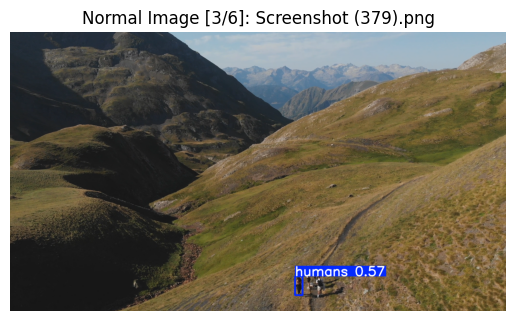

-------------------------
⚠️ Error: Image file not found at /kaggle/input/rgb-images/image (1).jpg
-------------------------
Running inference on: 1200-675-23035670-thumbnail-16x9-flood.jpg

image 1/1 /kaggle/input/rgb-images/1200-675-23035670-thumbnail-16x9-flood.jpg: 384x640 1 humans, 56.2ms
Speed: 1.9ms preprocess, 56.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


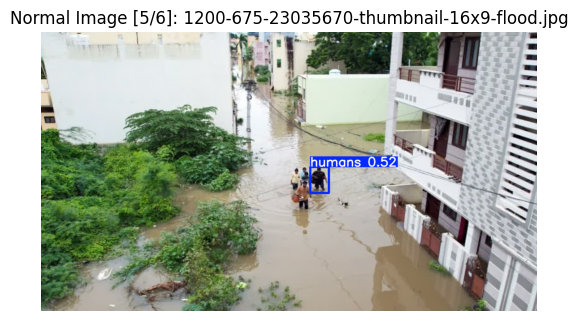

-------------------------
Running inference on: W087-0456-003-e1689975062161.jpg

image 1/1 /kaggle/input/rgb-images/W087-0456-003-e1689975062161.jpg: 384x640 7 humanss, 56.1ms
Speed: 1.9ms preprocess, 56.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


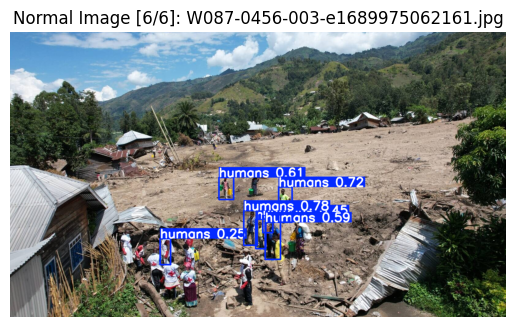

-------------------------

🔥 Running Inference on Thermal Images...
Running inference on: sensors-23-09216-g001.png

image 1/1 /kaggle/input/thermal-images/sensors-23-09216-g001.png: 544x640 3 persons, 72.5ms
Speed: 2.6ms preprocess, 72.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


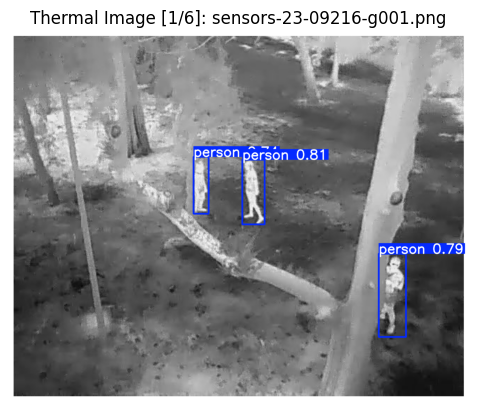

-------------------------
Running inference on: 190003.jpg

image 1/1 /kaggle/input/thermal-images/190003.jpg: 512x640 5 persons, 54.2ms
Speed: 2.0ms preprocess, 54.2ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


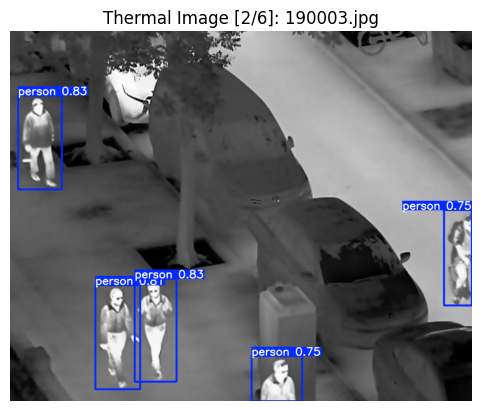

-------------------------
Running inference on: FLIR_07538_jpeg_jpg.rf.62bf28b984602aa4263620ad277675c8.jpg

image 1/1 /kaggle/input/thermal-images/FLIR_07538_jpeg_jpg.rf.62bf28b984602aa4263620ad277675c8.jpg: 640x640 6 persons, 54.9ms
Speed: 1.5ms preprocess, 54.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


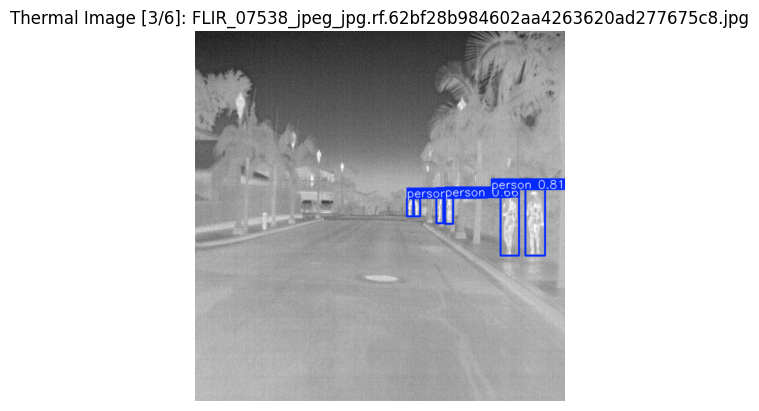

-------------------------
Running inference on: thermal2.jpg

image 1/1 /kaggle/input/thermal-images/thermal2.jpg: 480x640 1 person, 45.9ms
Speed: 1.8ms preprocess, 45.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


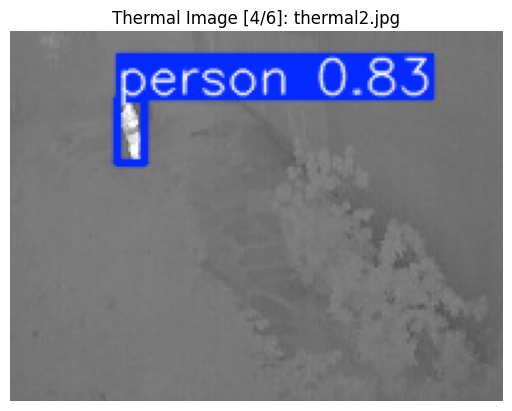

-------------------------
Running inference on: 010027.jpg

image 1/1 /kaggle/input/thermal-images/010027.jpg: 512x640 5 persons, 40.7ms
Speed: 2.2ms preprocess, 40.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


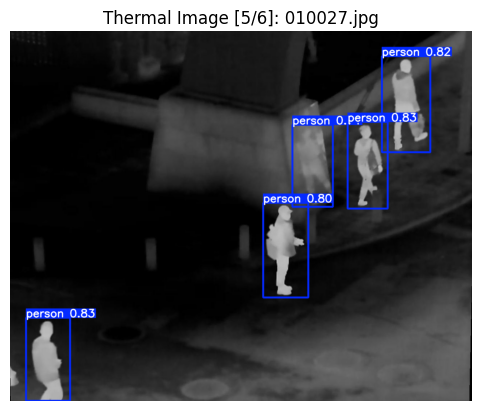

-------------------------
Running inference on: thermal3.jpeg

image 1/1 /kaggle/input/thermal-images/thermal3.jpeg: 544x640 2 persons, 51.6ms
Speed: 2.0ms preprocess, 51.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


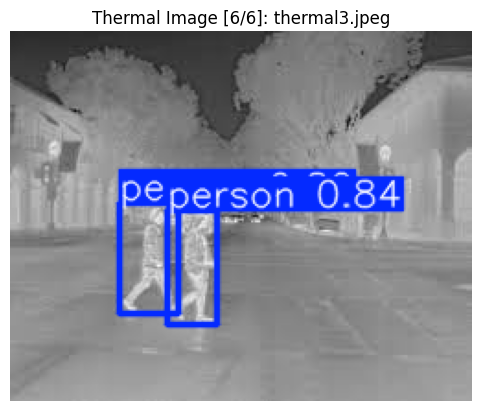

-------------------------

🔊 Running Inference on Audio Files...
Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


🔊 Audio Inference Result for shout-104972.mp3: Human Detected
-------------------------
Using device: cuda
🔊 Audio Inference Result for PES University Road 5.m4a: Human Detected
-------------------------


In [2]:
import os
import cv2
import torch
import torchaudio
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from ultralytics import YOLO

# ─── PATHS ────────────────────────────────────────────────
# These paths are set up for the Kaggle environment
ROOT = "/kaggle/input"
MODEL_PATHS = {
    "image": os.path.join(ROOT, "dl-models/other/default/1/image.pt"),
    "thermal": os.path.join(ROOT, "dl-models/other/default/1/thermal.pt"),
    "audio": os.path.join(ROOT, "dl-models/other/default/1/screaming_detector_gpu.pth"),
}

# 🔽 ACTION REQUIRED: Update the folder names below to point to your data directories 🔽
INPUT_PATHS = {
    "image": os.path.join(ROOT, "rgb-images"),  # <-- FOLDER containing normal images
    "thermal": os.path.join(ROOT, "thermal-images"), # <-- FOLDER containing thermal images
    "audio": os.path.join(ROOT, "audio-data"),     # <-- FOLDER containing audio files
}

# Supported file extensions for each data type
SUPPORTED_EXTENSIONS = {
    "image": ('.png', '.jpg', '.jpeg'),
    "thermal": ('.png', '.jpg', '.jpeg'),
    "audio": ('.m4a', '.wav', '.mp3', '.flac'),
}

class AudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        in_f = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_f, 2)

    def forward(self, x):
        return self.backbone(x)

# Helper to rename keys in state_dict
def convert_state_dict_keys(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("resnet."):
            new_key = k.replace("resnet.", "backbone.")
        else:
            new_key = k
        new_state_dict[new_key] = v
    return new_state_dict

def show_img(img, title=""):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

def run_yolo_inference(model_path, image_path, label="YOLO Output"):
    """Runs YOLO inference and displays the result."""
    if not os.path.exists(image_path) or image_path=="/kaggle/input/rgb-images/image (1).jpg" :
        print(f"⚠️ Error: Image file not found at {image_path}")
        return
    print(f"Running inference on: {os.path.basename(image_path)}")
    model = YOLO(model_path)
    results = model(image_path)
    img = results[0].plot()
    show_img(img, title=label)

def run_audio_inference(model_path, audio_path):
    """Runs audio classification inference and prints the result."""
    if not os.path.exists(audio_path):
        print(f"⚠️ Error: Audio file not found at {audio_path}")
        return
        
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    model = AudioClassifier()
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(convert_state_dict_keys(state_dict))
    model.to(device)
    model.eval()

    try:
        wave, sr = torchaudio.load(audio_path)
        wave = wave.to(device)
        
        target_sr, dur = 22050, 22050 * 3
        if sr != target_sr:
            wave = torchaudio.transforms.Resample(sr, target_sr).to(device)(wave)
        if wave.ndim > 1: wave = wave.mean(dim=0, keepdim=True)
        if wave.shape[-1] < dur: wave = torch.nn.functional.pad(wave, (0, dur - wave.shape[-1]))
        else: wave = wave[..., :dur]

        mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=target_sr, n_mels=64).to(device)
        mel = mel_transform(wave)
        spec = torch.log(mel + 1e-9).unsqueeze(0)

        with torch.no_grad():
            output = model(spec)
        
        pred = "Human Detected" if int(output.argmax()) == 1 else "No Human"
        print(f"🔊 Audio Inference Result for {os.path.basename(audio_path)}: {pred}")

    except Exception as e:
        print(f"🔴 Error processing audio file {os.path.basename(audio_path)}: {e}")


def get_files_from_folder(folder_path, extensions):
    """Gets all files with specified extensions from a folder."""
    if not os.path.isdir(folder_path):
        print(f"⚠️ Warning: Directory not found at {folder_path}")
        return []
    
    files = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.lower().endswith(extensions)
    ]
    
    if not files:
        print(f"ℹ️ No files with extensions {extensions} found in {folder_path}")
        
    return files


print("=========================================")
print("🖼️  Running Inference on Normal Images...")
print("=========================================")
image_files = get_files_from_folder(INPUT_PATHS["image"], SUPPORTED_EXTENSIONS["image"])
if image_files:
    for i, img_path in enumerate(image_files):
        run_yolo_inference(
            MODEL_PATHS["image"], 
            img_path, 
            label=f"Normal Image [{i+1}/{len(image_files)}]: {os.path.basename(img_path)}"
        )
        print("-" * 25)

# --- 2. Thermal Image Inferences ---
print("\n===========================================")
print("🔥 Running Inference on Thermal Images...")
print("===========================================")
thermal_files = get_files_from_folder(INPUT_PATHS["thermal"], SUPPORTED_EXTENSIONS["thermal"])
if thermal_files:
    for i, img_path in enumerate(thermal_files):
        run_yolo_inference(
            MODEL_PATHS["thermal"], 
            img_path, 
            label=f"Thermal Image [{i+1}/{len(thermal_files)}]: {os.path.basename(img_path)}"
        )
        print("-" * 25)

# --- 3. Audio Inference ---
print("\n======================================")
print("🔊 Running Inference on Audio Files...")
print("======================================")
audio_files = get_files_from_folder(INPUT_PATHS["audio"], SUPPORTED_EXTENSIONS["audio"])
if audio_files:
    for audio_path in audio_files:
        run_audio_inference(MODEL_PATHS["audio"], audio_path)
        print("-" * 25)

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.1 MB/s eta 0:00:00:00:0100:01
  Attempting unins